In [1]:
!pip install folium



   -------------------- ------------------- 1/2 [folium]
   ---------------------------------------- 2/2 [folium]



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from IPython.display import IFrame

%matplotlib inline
sns.set(style="whitegrid")


In [3]:
# Step 2: load dataset (change filename/path if required)
fn = "Accident_Dataset.csv"   # <-- change this if your file has another name
df = pd.read_csv(fn)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()


Shape: (7728394, 46)
Columns: ['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


In [4]:
# Step 3: detect a datetime-like column and parse it
possible_datetime_cols = [c for c in df.columns if c.lower() in (
    'start_time','starttime','date','datetime','time','incident_time','accident_date')]

if possible_datetime_cols:
    dt_col = possible_datetime_cols[0]
else:
    # fallback: any column with 'time' or 'date' in name
    dt_col = next((c for c in df.columns if 'time' in c.lower() or 'date' in c.lower()), None)

if dt_col is None:
    raise ValueError("No datetime-like column found. Rename your datetime column to 'Start_Time' or similar.")

print("Using datetime column:", dt_col)
df[dt_col] = pd.to_datetime(df[dt_col], errors='coerce')

# Basic check
print("Parsed datetimes: valid =", df[dt_col].notna().sum(), " NaT =", df[dt_col].isna().sum())

# Extract features
df['Hour'] = df[dt_col].dt.hour
df['DayOfWeek'] = df[dt_col].dt.day_name()
df['Month'] = df[dt_col].dt.month_name()


Using datetime column: Start_Time
Parsed datetimes: valid = 6985228  NaT = 743166


In [5]:
# Step 4: try to identify important columns automatically
candidates = {
    'weather': ['weather','weather_condition','weather_type','conditions'],
    'road': ['road_condition','roadsurface','road_surface','road_condition_desc'],
    'lat': ['latitude','lat'],
    'lon': ['longitude','lon','lng'],
    'severity': ['severity','severity_level','impact']
}

col_map = {}
for key, keys in candidates.items():
    found = next((c for c in df.columns if c.lower() in keys), None)
    col_map[key] = found

print("Detected columns:", col_map)

# If any lat/lon missing, list available columns so user can rename
if col_map['lat'] is None or col_map['lon'] is None:
    print("Latitude/Longitude not automatically detected. Rename your lat/lon columns or set them manually:")
    print(df.columns.tolist())


Detected columns: {'weather': 'Weather_Condition', 'road': None, 'lat': None, 'lon': None, 'severity': 'Severity'}
Latitude/Longitude not automatically detected. Rename your lat/lon columns or set them manually:
['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Hour', 'DayOfWeek', 'Month']


In [6]:
# Step 5: cleaning & normalize text columns
df_clean = df.copy()

# drop rows with missing lat/lon if both exist (for mapping). If lat/lon not present, skip drop.
if col_map['lat'] and col_map['lon']:
    df_clean = df_clean.dropna(subset=[col_map['lat'], col_map['lon']])

# Normalize string columns for nicer grouping
for c in [col_map['weather'], col_map['road']]:
    if c:
        df_clean[c] = df_clean[c].astype(str).str.strip().str.title().replace({'nan': np.nan})
        
# Ensure severity numeric if possible
if col_map['severity']:
    df_clean[col_map['severity']] = pd.to_numeric(df_clean[col_map['severity']], errors='coerce')

print("After cleaning shape:", df_clean.shape)


After cleaning shape: (7728394, 49)


In [7]:
# Step 6: quick stats & missing values
print("Top 10 columns by missing values:")
print(df_clean.isnull().sum().sort_values(ascending=False).head(10))
print("\nSample value counts (weather / road):")
if col_map['weather']:
    print(df_clean[col_map['weather']].value_counts().head(10))
if col_map['road']:
    print(df_clean[col_map['road']].value_counts().head(10))


Top 10 columns by missing values:
End_Lat              3402762
End_Lng              3402762
Precipitation(in)    2203586
Wind_Chill(F)        1999019
Start_Time            743166
Month                 743166
Hour                  743166
DayOfWeek             743166
Wind_Speed(mph)       571233
Visibility(mi)        177098
dtype: int64

Sample value counts (weather / road):
Weather_Condition
Fair                2560802
Mostly Cloudy       1016195
Cloudy               817082
Clear                808743
Partly Cloudy        698972
Overcast             382866
Light Rain           352957
Scattered Clouds     204829
Nan                  173459
Light Snow           128680
Name: count, dtype: int64


In [8]:
# Step 7: Road condition plot
plt.figure(figsize=(10,5))
if col_map['road'] and df_clean[col_map['road']].notna().any():
    order = df_clean[col_map['road']].value_counts().index
    sns.countplot(data=df_clean, x=col_map['road'], order=order)
    plt.title("Accidents by Road Condition")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Road condition column not detected or empty.")


Road condition column not detected or empty.


<Figure size 1000x500 with 0 Axes>

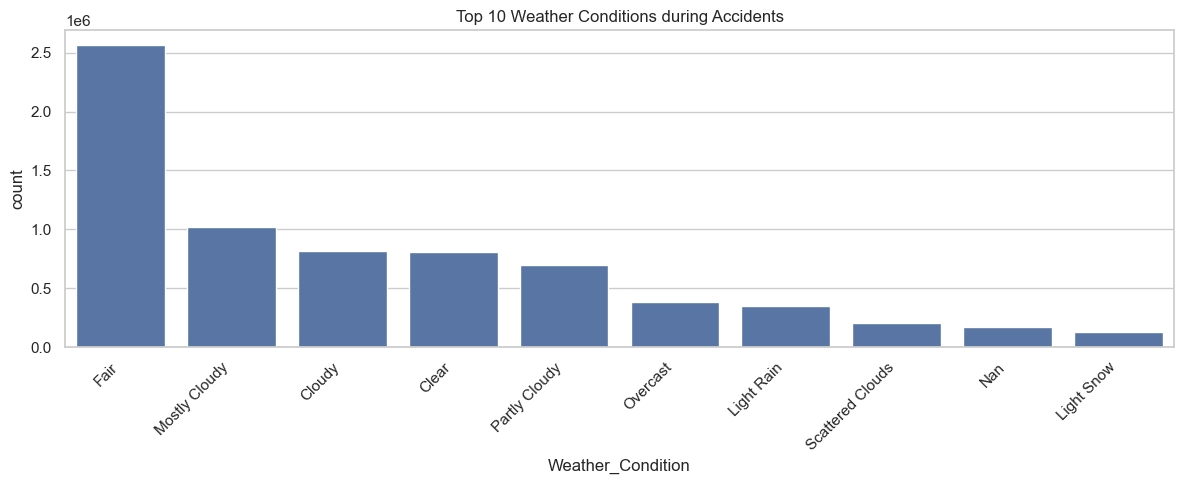

In [9]:
# Step 8: Weather condition plot (top 10)
plt.figure(figsize=(12,5))
if col_map['weather'] and df_clean[col_map['weather']].notna().any():
    top = df_clean[col_map['weather']].value_counts().head(10).index
    sns.countplot(data=df_clean, x=col_map['weather'], order=top)
    plt.title("Top 10 Weather Conditions during Accidents")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Weather column not detected or empty.")


In [10]:
# Step 10: create a HeatMap HTML (sample to limit memory)
if col_map['lat'] and col_map['lon'] and df_clean.shape[0] > 0:
    n = min(5000, len(df_clean))
    sample = df_clean.dropna(subset=[col_map['lat'], col_map['lon']]).sample(n=n, random_state=42)
    # convert lat/lon to float if strings
    sample[col_map['lat']] = sample[col_map['lat']].astype(float)
    sample[col_map['lon']] = sample[col_map['lon']].astype(float)

    center = [sample[col_map['lat']].mean(), sample[col_map['lon']].mean()]
    m = folium.Map(location=center, zoom_start=11)
    heat_data = list(zip(sample[col_map['lat']], sample[col_map['lon']]))
    HeatMap(heat_data, radius=8, blur=15, max_zoom=10).add_to(m)

    # Save & display
    out_html = "accident_hotspots.html"
    m.save(out_html)
    print("Saved heatmap to", out_html)
    # If in notebook environment, embed:
    try:
        display(IFrame(out_html, width=900, height=450))
    except Exception:
        pass
else:
    print("Latitude/Longitude columns not available for mapping.")


Latitude/Longitude columns not available for mapping.


<Figure size 1000x500 with 0 Axes>

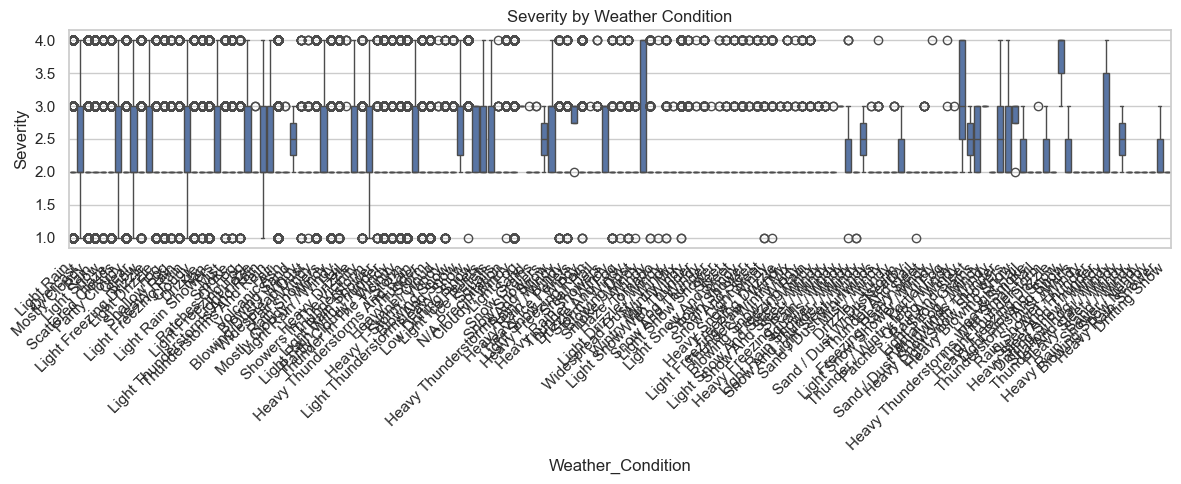

In [11]:
# Step 11: compare severity (if severity exists)
if col_map['severity']:
    plt.figure(figsize=(10,5))
    if col_map['road'] and df_clean[col_map['road']].notna().any():
        sns.boxplot(data=df_clean, x=col_map['road'], y=col_map['severity'])
        plt.xticks(rotation=45, ha='right')
        plt.title("Severity by Road Condition")
        plt.tight_layout()
        plt.show()
    if col_map['weather'] and df_clean[col_map['weather']].notna().any():
        plt.figure(figsize=(12,5))
        sns.boxplot(data=df_clean, x=col_map['weather'], y=col_map['severity'])
        plt.xticks(rotation=45, ha='right')
        plt.title("Severity by Weather Condition")
        plt.tight_layout()
        plt.show()
else:
    print("Severity column not detected (or non-numeric).")


In [12]:
# Step 12: try to find contributing-factor columns (cause, contrib, violation)
contrib_candidates = [c for c in df_clean.columns if any(k in c.lower() for k in ('contrib','cause','violation','reason'))]
if contrib_candidates:
    for col in contrib_candidates:
        print("\nTop values for", col)
        display(df_clean[col].value_counts().head(20))
        plt.figure(figsize=(10,6))
        sns.countplot(y=col, data=df_clean, order=df_clean[col].value_counts().head(20).index)
        plt.title(f"Top values in {col}")
        plt.tight_layout()
        plt.show()
else:
    print("No contributing-factor columns found automatically. Check column names if you have them.")
    
# Save some aggregated outputs
df_clean.to_csv("accidents_cleaned.csv", index=False)
agg_hour = df_clean.groupby('Hour').size().reset_index(name='count')
agg_hour.to_csv("accidents_by_hour.csv", index=False)
print("Saved cleaned data and sample aggregates (accidents_cleaned.csv, accidents_by_hour.csv).")


No contributing-factor columns found automatically. Check column names if you have them.
Saved cleaned data and sample aggregates (accidents_cleaned.csv, accidents_by_hour.csv).
